# IT4 All (> 10 words) AND (thumbsup >3.0)

Coding was developed based on below sources:
* Brandonrose.org. (2018). Document Clustering with Python. [online] Available at: http://brandonrose.org/clustering 
* Scikit-learn.org. (2018). sklearn.metrics.silhouette_score — scikit-learn 0.19.2 documentation. [online] Available at: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
* Twitterdev.github.io. (2018). Do More with Twitter Data — Do more with Twitter data 0.1 documentation. [online] Available at: https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpld3
import sys
import csv
import string

In [35]:
dsa_data = pd.read_csv('/Users/rmhiwku/depression-stress-anxiety.csv')
dsa_data = dsa_data.dropna() #filter out empty rows; otherwise it will fail later
dsa_data.columns = ['appname', 'rating', 'ratingcount', 'developer','apptype','reviewer','date','reviewer_rating','thumbsup','review']
dsa_data['words'] = dsa_data['review'].str.split()
dsa_data['word_len'] = dsa_data['words'].str.len()
print('Total reviews: ',len(dsa_data))

#filter in only if >1 people gave thumbs-up
dsa_data_useful = dsa_data[dsa_data.thumbsup>3.0]
print('Total number of reviews users vote useful: ', len(dsa_data_useful))

#filter in only if length is >10 words
dsa_data_useful = dsa_data_useful[dsa_data_useful.word_len>13]
print('Total number of reviews user voted useful & long review: ', len(dsa_data_useful))

len(dsa_data_useful.appname.unique())

Total reviews:  63474
Total number of reviews users vote useful:  3468
Total number of reviews user voted useful & long review:  2927


98

In [ ]:
dsa_data_useful.info()

In [3]:
appnames_all = dsa_data_useful['appname'].tolist()
reviews_all = dsa_data_useful['review'].tolist()

review_texts = reviews_all
print(len(review_texts))

2927


# Data Cleaning

In [4]:
# load NLTK's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['review','text','app',"also","would","stress","anxiety","depression","saying"]
stopwords.extend(newStopWords)
print (stopwords[:-1])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
# load NLTK's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [6]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [7]:
# use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in review_texts:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'review_texts', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

print("Number of vocab tokenized and stemmed: ", len(totalvocab_stemmed))
print("Number of vocab tokenized only: ",len(totalvocab_tokenized))

Number of vocab tokenized and stemmed:  61831
Number of vocab tokenized only:  61831


In [8]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 61831 items in vocab_frame


In [9]:
print (vocab_frame.head())

             words
great        great
keep       keeping
daili        daily
issu        issues
person  personally


In [10]:
# Count frequency of words
from collections import Counter
list1=totalvocab_stemmed
counts = Counter(list1)
print(counts)

Counter({'help': 1269, 'use': 864, 'realli': 675, 'love': 671, 'like': 670, 'medit': 660, 'great': 622, 'time': 566, 'get': 560, 'day': 499, 'one': 475, 'feel': 470, 'good': 443, 'work': 440, 'need': 423, 'peopl': 388, 'make': 378, 'thank': 370, 'tri': 367, 'much': 355, 'free': 343, 'want': 298, 'thing': 296, 'even': 293, 'could': 276, 'way': 275, 'give': 265, 'think': 263, 'pay': 254, 'keep': 248, 'listen': 233, 'lot': 232, 'recommend': 231, 'better': 229, 'life': 228, 'well': 223, 'therapist': 221, 'relax': 216, 'see': 214, 'first': 205, 'talk': 202, 'start': 201, 'month': 200, 'find': 199, 'mind': 195, 'know': 194, 'amaz': 193, 'thought': 193, 'app': 191, 'look': 181, 'mani': 180, 'back': 180, 'subscript': 175, 'chang': 172, 'person': 170, 'problem': 170, 'abl': 164, 'best': 163, 'differ': 162, 'take': 162, 'voic': 161, 'issu': 158, 'say': 158, 'easi': 158, 'go': 156, 'everi': 156, 'calm': 156, 'pleas': 153, 'year': 151, 'session': 150, 'track': 149, 'someth': 147, 'got': 147, 'supp

# Tfidf Vectorizer

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.01, stop_words=stopwords,
                                   use_idf=True,
                                   tokenizer=tokenize_and_stem, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(review_texts) #fit the vectorizer to review_texts

print(tfidf_matrix.shape)

Wall time: 3 s
(2927, 412)


In [15]:
# Etermining what terms are useful enough to turn into features
terms = tfidf_vectorizer.get_feature_names()
print(len(terms))
terms

412


['abl',
 'absolut',
 'access',
 'account',
 'accur',
 'activ',
 'actual',
 'ad',
 'add',
 'advic',
 'afford',
 'ago',
 'allow',
 'almost',
 'alreadi',
 'alway',
 'amaz',
 'annoy',
 'anoth',
 'answer',
 'anyon',
 'anyth',
 'appreci',
 'around',
 'ask',
 'asleep',
 'attack',
 'audio',
 'avail',
 'awar',
 'away',
 'awesom',
 'back',
 'background',
 'bad',
 'basic',
 'beauti',
 'becom',
 'begin',
 'beginn',
 'believ',
 'benefit',
 'best',
 'better',
 'big',
 'bit',
 'bless',
 'bought',
 'breath',
 'bring',
 'bug',
 'button',
 'buy',
 'calm',
 'cant',
 'care',
 'caus',
 'cbt',
 'chang',
 'charg',
 'chat',
 'check',
 'choos',
 'clear',
 'close',
 'come',
 'comment',
 'communiti',
 'complet',
 'concept',
 'connect',
 'constant',
 'contact',
 'content',
 'continu',
 'control',
 'convers',
 'cost',
 'could',
 'coupl',
 'cours',
 'crash',
 'creat',
 'current',
 'custom',
 'daili',
 'data',
 'day',
 'deal',
 'definit',
 'depress',
 'design',
 'develop',
 'devic',
 'differ',
 'difficult',
 'disapp

In [16]:
# dist is defined as 1 - the cosine similarity of each document. 
# Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity 
# between each document and the other documents in the corpus (each review among the reviews). 
# Subtracting it from 1 provides cosine distance which is used for plotting on a euclidean (2-dimensional) plane.
from sklearn.metrics.pairwise import cosine_similarity
%time dist = 1 - cosine_similarity(tfidf_matrix)

Wall time: 152 ms


# K-means clustering

In [18]:
import pandas
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Elbow Curve - Finding the best parameter

Wall time: 4min 28s


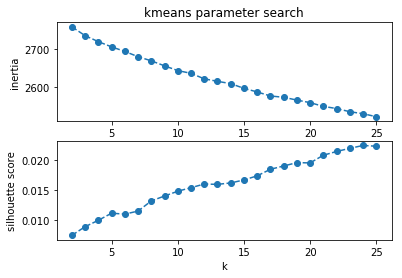

In [19]:
%%time

import logging
from sklearn.metrics import silhouette_score
seed = 42

# compare a broad range of ks to start
ks = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]

# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(tfidf_matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(tfidf_matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

## (7 Clusters)

In [20]:
# Do KMeans clustering to get the clusters
#from sklearn.cluster import KMeans

num_clusters = 7

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 6.26 s


In [21]:
# Use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle
joblib.dump(km,  'doc_cluster4-1.pkl')

km = joblib.load('doc_cluster4-1.pkl')
clusters = km.labels_.tolist()

In [22]:
# Create dictionary
appreview = { 'review': review_texts, 'cluster': clusters}
frame = pd.DataFrame(appreview, index = [clusters] , columns = ['reviews','cluster'])

In [23]:
#number of reviews per cluster (clusters from 0 to 6)
frame['cluster'].value_counts()

2    1070
6     491
3     330
5     292
0     272
4     253
1     219
Name: cluster, dtype: int64

In [24]:
# indexing and sorting on each cluster to identify which are the top n (I used n=50) words that are nearest 
# to the cluster centroid. This gives a good sense of the main topic of the cluster.
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :50]: #replace with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')

    print() #add whitespace
    print() #add whitespace

print()

Top terms per cluster:

Cluster 0 words: love, helpful, using, really, great, relax, much, day, gets, thanks, games, making, feel, things, time, one, recommend, good, absolutely, mindfulness, calming, way, give, needs, well, life, could, different, keeping, many, sleep, best, definitely, easy, able, always, see, meditation, awesome, headspace, amazing, every, going, problem, listen, something, thoughts, fun, think, moments,

Cluster 1 words: worked, great, using, really, well, good, gets, like, helpful, trying, needs, love, keeping, issues,

C:\Users\rmhiwku\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


 even, phone, therapist, time, got, message, think, back, please, sometimes, first, fix, playing, problem, making, things, could, best, day, always, way, update, meditation, much, reminders, thanks, improved, relax, see, content, start, accurately, stops, loading, idea, one,

Cluster 2 words: like, using, great, good, gets, one, making, feel, needs, really, day, therapist, talking, trying, way, people, listen, thanks, wanted, give, even, could, better, says, amazing, know, things, think, please, change, keeping, someone, option, see, update, look, find, adding, problem, asking, lot, relax, back, something, first, read, life, recommend, nice, voice,

Cluster 3 words: meditation, guided, day, great, using, like, session, love, mindfulness, really, voice, start, helpful, headspace, trying, good, recommend, one, gets, music, calming, free, minutes, time, making, enjoying, practices, feel, thanks, relax, life, playing, things, much, easy, year, focused, find, simple, different, needs, best,

# Multidimensional scaling

In [25]:
# convert the dist matrix into a 2-dimensional array using multidimensional scaling (MDS)
import os  # for os.path.basename
from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()


Wall time: 5min 19s



In [26]:
#save nparray
a = pos
np.savetxt("IT4POSnparray-1.csv", a, delimiter=",")

# Visualizing document clusters

In [27]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
                  5: '#5B1B9E', 6: '#9E1B7E', 7: '#9E1B22', 8: '#969E1B', 9: '#D3F22F',
                  10: '#F2602F', 11: '#50C7F4', 12: '#8ECE92', 13: '#E79FC0', 14: '#74045E',
                  15: '#EC86DD', 16: '#508DF4', 17: '#F4EB10', 18: '#C94E86', 19: '#5C45A5',
                  20: '#F0D0EB', 21: '#109C19', 22: '#E7E59F', 23: '#740437', 24: '#1AAEC3'}

#set up cluster names using a dict
cluster_names = {0: 'cluster1', 
                 1: 'cluster2', 
                 2: 'cluster3',
                 3: 'cluster4',
                 4: 'cluster5', 
                 5: 'cluster6', 
                 6: 'cluster7'}

### First, define some dictionaries for going from cluster number to color and to cluster name. Then, based the cluster names off the words that were closest to each cluster centroid.

C:\Users\rmhiwku\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


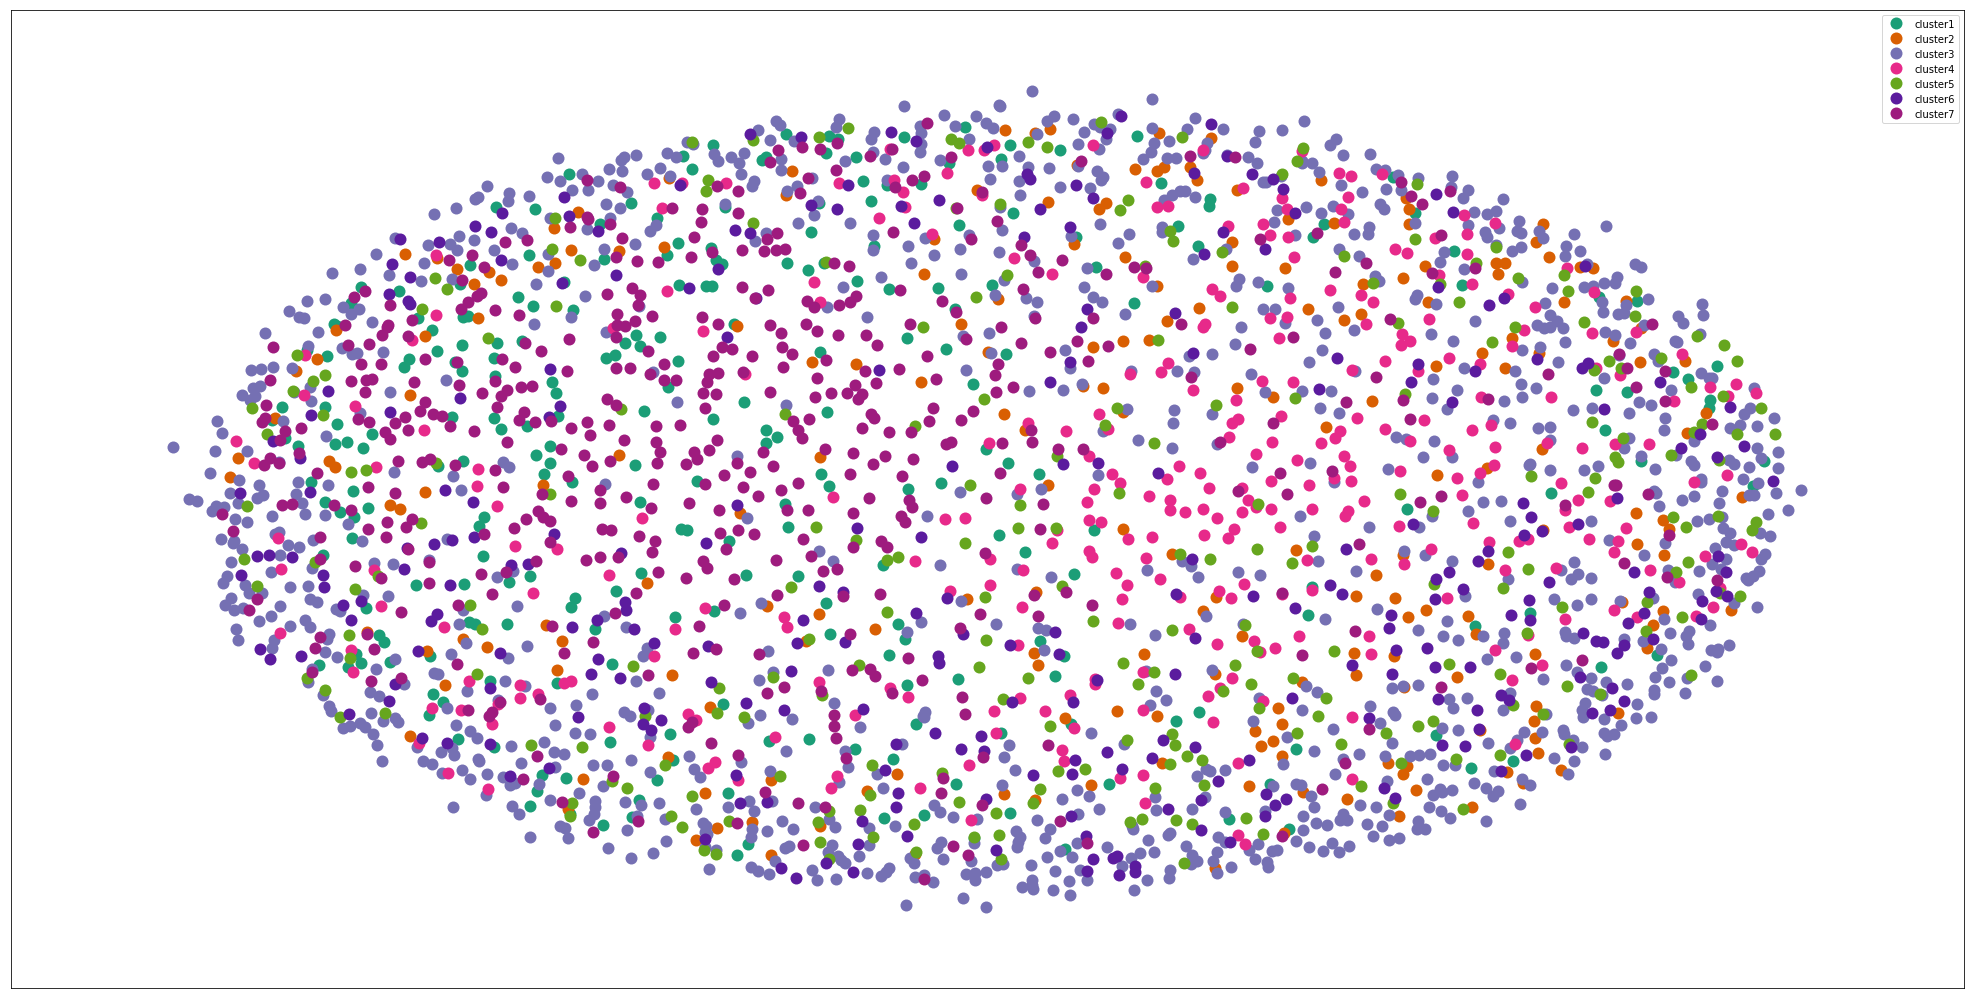

<Figure size 432x288 with 0 Axes>

In [28]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, review=review_texts)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(35, 18)) # set size
ax.margins(0.1) # add padding

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters.png', dpi=200)

In [ ]:
plt.close()